In [1]:
"""
Description:
    Load an IDF file and generate the input/s for a Radiance simulation
Arguments:
    path [string]: JSON config file (and referenced IDF within that config file)
Returns:
    Radiance simulation recipe/s [file objects]: Radiance simulation input/s

Annotations:
    TODO - Orient analysis grid to longest edge of zone it's being generated for
    TODO - Create ability to visualise surfaces and analsyis grids in context
    TODO - Add radiance parameters to the config.json to put into the generated recipes
    TODO - Add method interpreting results for SDA, DA, DF, UDI, UDILess, UDIMore
"""

# Load necessary packages
import sys
sys.path.insert(0, 'ladybug')
sys.path.insert(0, 'honeybee')
from honeybee.hbsurface import HBSurface
from honeybee.hbfensurface import HBFenSurface
from honeybee.radiance.analysisgrid import AnalysisGrid
from honeybee.radiance.properties import RadianceProperties
from honeybee.radiance.material.glass import Glass
from honeybee.radiance.material.plastic import Plastic
import matplotlib.patches as patches
from honeybee.radiance.sky.skymatrix import SkyMatrix
from honeybee.radiance.recipe.daylightfactor.gridbased import GridBased as GridBasedDF
from honeybee.radiance.recipe.annual.gridbased import GridBased as GridBasedAnnual
import os
import eppy
from eppy.modeleditor import IDF
import json
import numpy as np
import platform

Path to radiance is set to: /usr/local/radiance
Path to perl is set to: /usr/bin


In [10]:
def load_json(path):
    """
    Description:
        Load a JSON file into a dictionary object
    Arguments:
        path [string]: The location of the JSON file being loaded
    Returns:
        dictionary [dict]: Dictionary containing contents of loaded JSON file
    """
    with open(path) as data_file:
        return json.load(data_file)

# Specify the config file to be referenced
CONFIG = load_json("idf_config.json") #load_json(sys.argv[1])

# Load IDF ready for pre-processing and radaince case preparation
IDF_FILE = CONFIG["source_idf"]
if "win" in platform.platform().lower() and "dar" not in platform.platform().lower():
    IDF.setiddname(CONFIG["idd_file_windows"])
elif "linux" in platform.platform().lower():
    IDF.setiddname(CONFIG["idd_file_linux"])
elif "dar" in platform.platform().lower():
    IDF.setiddname(CONFIG["idd_file_os"])

EPW_FILE = CONFIG["weather_file"]
idf = IDF(IDF_FILE)

# Set the "vector to north", so that wall orientation can be obtained
north_angle = np.radians(idf.idfobjects["BUILDING"][0].North_Axis)
north_vector = (np.sin(north_angle), np.cos(north_angle), 0)


def unit_vector(vector):
    """
    Description:
        Returns the unit vector of a vector
    Arguments:
        vector [1D-array]: Vector defined as [n.n, n.n, n.n]
    Returns:
        vector [1D-array]: Dictionary containing contents of loaded JSON file
    """
    return vector / np.linalg.norm(vector)


def angle_between(vector_1, vector_2):
    """ Returns the angle in radians between vectors 'vector_1' and 'vector_2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    vector_1_u = unit_vector(vector_1)
    vector_2_u = unit_vector(vector_2)
    return np.arccos(np.clip(np.dot(vector_1_u, vector_2_u), -1.0, 1.0))


def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    o_x, o_y = origin
    p_x, p_y = point

    q_x = o_x + np.cos(angle) * (p_x - o_x) - np.sin(angle) * (p_y - o_y)
    q_y = o_y + np.sin(angle) * (p_x - o_x) + np.cos(angle) * (p_y - o_y)
    return q_x, q_y

In [11]:
# Define materials to be applied to surfaces
glass_material_N = Glass(
    "GlassMaterialN",
    r_transmittance=CONFIG["glass_visible_transmittance_N"],
    g_transmittance=CONFIG["glass_visible_transmittance_N"],
    b_transmittance=CONFIG["glass_visible_transmittance_N"],
    refraction_index=1.52
    )

glass_material_S = Glass(
    "GlassMaterialS",
    r_transmittance=CONFIG["glass_visible_transmittance_S"],
    g_transmittance=CONFIG["glass_visible_transmittance_S"],
    b_transmittance=CONFIG["glass_visible_transmittance_S"],
    refraction_index=1.52
)

glass_material_E = Glass(
    "GlassMaterialE",
    r_transmittance=CONFIG["glass_visible_transmittance_E"],
    g_transmittance=CONFIG["glass_visible_transmittance_E"],
    b_transmittance=CONFIG["glass_visible_transmittance_E"],
    refraction_index=1.52
)

glass_material_W = Glass(
    "GlassMaterialW",
    r_transmittance=CONFIG["glass_visible_transmittance_W"],
    g_transmittance=CONFIG["glass_visible_transmittance_W"],
    b_transmittance=CONFIG["glass_visible_transmittance_W"],
    refraction_index=1.52
)

glass_material_interior = Glass(
    "GlassMaterialInternal",
    r_transmittance=0.9,
    g_transmittance=0.9,
    b_transmittance=0.9,
    refraction_index=1.52
)

glass_material_skylight = Glass(
    "GlassMaterialSkylight",
    r_transmittance=CONFIG["glass_visible_transmittance_skylight"],
    g_transmittance=CONFIG["glass_visible_transmittance_skylight"],
    b_transmittance=CONFIG["glass_visible_transmittance_skylight"],
    refraction_index=1.52
)

air_wall_material = Glass(
    "AirWallMaterial",
    r_transmittance=0,
    g_transmittance=0,
    b_transmittance=0,
    refraction_index=1
)

wall_material = Plastic(
    "WallMaterial",
    r_reflectance=CONFIG["wall_reflectivity"],
    g_reflectance=CONFIG["wall_reflectivity"],
    b_reflectance=CONFIG["wall_reflectivity"],
    specularity=0,
    roughness=0
)

ceiling_material = Plastic(
    "CeilingMaterial",
    r_reflectance=CONFIG["ceiling_reflectivity"],
    g_reflectance=CONFIG["ceiling_reflectivity"],
    b_reflectance=CONFIG["ceiling_reflectivity"],
    specularity=0,
    roughness=0
)

floor_material = Plastic(
    "FloorMaterial",
    r_reflectance=CONFIG["floor_reflectivity"],
    g_reflectance=CONFIG["floor_reflectivity"],
    b_reflectance=CONFIG["floor_reflectivity"],
    specularity=0,
    roughness=0
)

# Assign surfaces within IDF to HBSurfaces for daylight analysis
EXTERIOR_WALL_SURFACES = []
for wall_n, wall in enumerate([i for i in idf.idfobjects["BUILDINGSURFACE:DETAILED"] if i.Construction_Name == "Exterior Wall"]):
    srf = HBSurface(
        "wall_{0:}_{1:}".format(wall_n, wall.Name),
        wall.coords,
        surface_type=0,
        is_name_set_by_user=True,
        is_type_set_by_user=True,
        rad_properties=RadianceProperties(
            material=wall_material
        )
    )
    angle_to_north = np.degrees(angle_between(north_vector, srf.normal))
    for fenestration_n, fenestration in enumerate(idf.idfobjects["FENESTRATIONSURFACE:DETAILED"]):
        if wall.Name in fenestration.Name:
            # Assign glass properties based on orientation
            if (angle_to_north > 315) or (angle_to_north <= 45):
                orientation_glass_material = glass_material_N
            elif (angle_to_north > 45) and (angle_to_north <= 135):
                orientation_glass_material = glass_material_E
            elif (angle_to_north > 135) and (angle_to_north <= 225):
                orientation_glass_material = glass_material_S
            elif (angle_to_north > 225) and (angle_to_north <= 315):
                orientation_glass_material = glass_material_W
            fensrf = HBFenSurface(
                "wall_{0:}_{1:}_fenestration_{2:}_{3:}".format(wall_n, wall.Name, fenestration_n, fenestration.Name),
                fenestration.coords,
                rad_properties=RadianceProperties(
                    material=orientation_glass_material
                )
            )
            srf.add_fenestration_surface(fensrf)
    EXTERIOR_WALL_SURFACES.append(srf)

INTERIOR_WALL_SURFACES = []
for wall_n, wall in enumerate([i for i in idf.idfobjects["BUILDINGSURFACE:DETAILED"] if i.Construction_Name == "Interior Wall"]):
    srf = HBSurface(
        "wall_{0:}_{1:}".format(wall_n, wall.Name),
        wall.coords,
        surface_type=0,
        is_name_set_by_user=True,
        is_type_set_by_user=True,
        rad_properties=RadianceProperties(
            material=wall_material
        )
    )
    for fenestration_n, fenestration in enumerate(idf.idfobjects["FENESTRATIONSURFACE:DETAILED"]):
        if wall.Name in fenestration.Name:
            fensrf = HBFenSurface(
                "wall_{0:}_{1:}_fenestration_{2:}_{3:}".format(wall_n, wall.Name, fenestration_n, fenestration.Name),
                fenestration.coords,
                rad_properties=RadianceProperties(
                    material=glass_material_interior
                )
            )
            srf.add_fenestration_surface(fensrf)
    INTERIOR_WALL_SURFACES.append(srf)

AIRWALL_SURFACES = []
for airwall_n, airwall in enumerate([i for i in idf.idfobjects["BUILDINGSURFACE:DETAILED"] if i.Construction_Name == "Air Wall"]):
    srf = HBSurface("airwall_{0:}_{1:}".format(airwall_n, airwall.Name), airwall.coords, surface_type=4, is_name_set_by_user=True, is_type_set_by_user=True, rad_properties=RadianceProperties(material=air_wall_material))
    AIRWALL_SURFACES.append(srf)

FLOOR_SURFACES = []
for floor_n, floor in enumerate([i for i in idf.idfobjects["BUILDINGSURFACE:DETAILED"] if (i.Construction_Name == "Interior Floor") or (i.Construction_Name == "Exterior Floor") or (i.Construction_Name == "Exposed Floor")]):
    srf = HBSurface("floor_{0:}_{1:}".format(floor_n, floor.Name), floor.coords, surface_type=2, is_name_set_by_user=True, is_type_set_by_user=True, rad_properties=RadianceProperties(material=floor_material))
    for fenestration_n, fenestration in enumerate(idf.idfobjects["FENESTRATIONSURFACE:DETAILED"]):
        if floor.Name in fenestration.Name:
            fensrf = HBFenSurface("floor_{0:}_{1:}_fenestration_{2:}_{3:}".format(floor_n, floor.Name, fenestration_n, fenestration.Name), fenestration.coords, rad_properties=RadianceProperties(material=glass_material_interior))
            srf.add_fenestration_surface(fensrf)
    FLOOR_SURFACES.append(srf)

CEILING_SURFACES = []
for ceiling_n, ceiling in enumerate([i for i in idf.idfobjects["BUILDINGSURFACE:DETAILED"] if (i.Construction_Name == "Interior Ceiling") or (i.Construction_Name == "Exterior Ceiling") or (i.Construction_Name == "Roof")]):
    srf = HBSurface("ceiling_{0:}_{1:}".format(ceiling_n, ceiling.Name), ceiling.coords, surface_type=3, is_name_set_by_user=True, is_type_set_by_user=True, rad_properties=RadianceProperties(material=ceiling_material))
    for fenestration_n, fenestration in enumerate(idf.idfobjects["FENESTRATIONSURFACE:DETAILED"]):
        if ceiling.Name in fenestration.Name:
            fensrf = HBFenSurface("ceiling_{0:}_{1:}_fenestration_{2:}_{3:}".format(ceiling_n, ceiling.Name, fenestration_n, fenestration.Name), fenestration.coords, rad_properties=RadianceProperties(material=glass_material_skylight))
            srf.add_fenestration_surface(fensrf)
    CEILING_SURFACES.append(srf)

CONTEXT_SURFACES = []
for context_n, context in enumerate([i for i in idf.idfobjects["SHADING:BUILDING:DETAILED"]]):
    srf = HBSurface("context_{0:}_{1:}".format(context_n, context.Name), context.coords, surface_type=6, is_name_set_by_user=True, is_type_set_by_user=True, rad_properties=RadianceProperties(material=wall_material))
    CONTEXT_SURFACES.append(srf)

HB_OBJECTS = np.concatenate([EXTERIOR_WALL_SURFACES, INTERIOR_WALL_SURFACES, FLOOR_SURFACES, CEILING_SURFACES, AIRWALL_SURFACES, CONTEXT_SURFACES]).tolist()

In [12]:
# Define analysis grids for each zone for simulation in Radiance
HB_ANALYSIS_GRIDS = []
for floor_srf in [i for i in idf.idfobjects["BUILDINGSURFACE:DETAILED"] if ("Floor" in i.Construction_Name)]:
    vert_xs, vert_ys, vert_zs = list(zip(*floor_srf.coords))
    patch = patches.Polygon(list(zip(*[vert_xs, vert_ys])))
    min_x, max_x, min_y, max_y, max_z = min(vert_xs), max(vert_xs), min(vert_ys), max(vert_ys), max(vert_zs)
    x_range = max_x - min_x
    y_range = max_y - min_y
    g = np.meshgrid(
        np.arange(min_x - (x_range / 2), max_x + (x_range / 2), CONFIG["daylight_analysis_grid_spacing"]),
        np.arange(min_y - (y_range / 2), max_y + (y_range / 2), CONFIG["daylight_analysis_grid_spacing"])
    )
    COORDS = list(zip(*(c.flat for c in g)))
    ANALYSIS_POINTS = np.vstack([p for p in COORDS if patch.contains_point(p, radius=CONFIG["daylight_analysis_grid_edge_offset"])])
    GRID_POINTS = list(zip(*[np.array(list(zip(*ANALYSIS_POINTS)))[0], np.array(list(zip(*ANALYSIS_POINTS)))[1], np.repeat(max_z+CONFIG["daylight_analysis_grid_surface_offset"], len(ANALYSIS_POINTS))]))
    HB_ANALYSIS_GRIDS.append(AnalysisGrid.from_points_and_vectors(GRID_POINTS, name=floor_srf.Zone_Name))
    print(floor_srf.Zone_Name)

CM2_Adj_00
CM2_Adj_01
CM2_Adj_02
CM2_S_Outer
CM2_S_Inner
CM2_N_Outer
CM2_N_Inner
CM2_E_Outer
CM2_E_Inner
CM2_W_Outer
CM2_W_Inner
CM1_Adj_00
CM1_Adj_01
CM1_Adj_02
CM1_N_Outer
CM1_N_Inner
CM1_E_Outer
CM1_E_Inner
CM1_SE_Outer
CM1_SE_Inner
CM1_SW_Outer
CM1_SW_Inner
CM1_NW_Outer
CM1_NW_Inner


In [13]:
# Generate sky matrix for annual analysis
SKY_MATRIX = SkyMatrix.from_epw_file(EPW_FILE, sky_density=2, north=0, hoys=range(0, 8760), mode=0, suffix="")

# Create the analysis recipes for each IDF zone
for HB_ANALYSIS_GRID in HB_ANALYSIS_GRIDS:

    # Create a directory in which to save the DF recipe/s
    DF_RECIPE_DIR = CONFIG["output_directory"]+"/"+HB_ANALYSIS_GRID.name+"/daylight_factor"
    if not os.path.exists(DF_RECIPE_DIR):
        os.makedirs(DF_RECIPE_DIR)

    # Generate a DF recipe as JSON and save [WITHOUT CONTEXT GEOMETRY]
    with open(DF_RECIPE_DIR+"/recipe.json", "w") as f:
        json.dump(GridBasedDF(analysis_grids=[HB_ANALYSIS_GRID], hb_objects=[]).to_json(), f)

    # Create a directory in which to save the Annual recipe/s
    ANNUAL_RECIPE_DIR = CONFIG["output_directory"]+"/"+HB_ANALYSIS_GRID.name+"/annual"
    if not os.path.exists(ANNUAL_RECIPE_DIR):
        os.makedirs(ANNUAL_RECIPE_DIR)

    # Generate an ANNUAL recipe as JSON and save [WITHOUT CONTEXT GEOMETRY]
    with open(ANNUAL_RECIPE_DIR+"/recipe.json", "w") as f:
        json.dump(GridBasedAnnual(SKY_MATRIX, analysis_grids=[HB_ANALYSIS_GRID], hb_objects=[]).to_json(), f)

# Write the context geometry to a seperate file
with open(CONFIG["output_directory"]+"/geometry.json", "w") as f:
    f.write(repr({"surfaces": [i.to_json() for i in HB_OBJECTS]}).replace("'", '"').replace("(", '[').replace(")", ']'))


Found 0 opaque surfaces.
Found 0 fenestration surfaces.
Found 0 window-groups.
Found 0 opaque surfaces.
Found 0 fenestration surfaces.
Found 0 window-groups.
Found 0 opaque surfaces.
Found 0 fenestration surfaces.
Found 0 window-groups.
Found 0 opaque surfaces.
Found 0 fenestration surfaces.
Found 0 window-groups.
Found 0 opaque surfaces.
Found 0 fenestration surfaces.
Found 0 window-groups.
Found 0 opaque surfaces.
Found 0 fenestration surfaces.
Found 0 window-groups.
Found 0 opaque surfaces.
Found 0 fenestration surfaces.
Found 0 window-groups.
Found 0 opaque surfaces.
Found 0 fenestration surfaces.
Found 0 window-groups.
Found 0 opaque surfaces.
Found 0 fenestration surfaces.
Found 0 window-groups.
Found 0 opaque surfaces.
Found 0 fenestration surfaces.
Found 0 window-groups.
Found 0 opaque surfaces.
Found 0 fenestration surfaces.
Found 0 window-groups.
Found 0 opaque surfaces.
Found 0 fenestration surfaces.
Found 0 window-groups.
Found 0 opaque surfaces.
Found 0 fenestration surfac

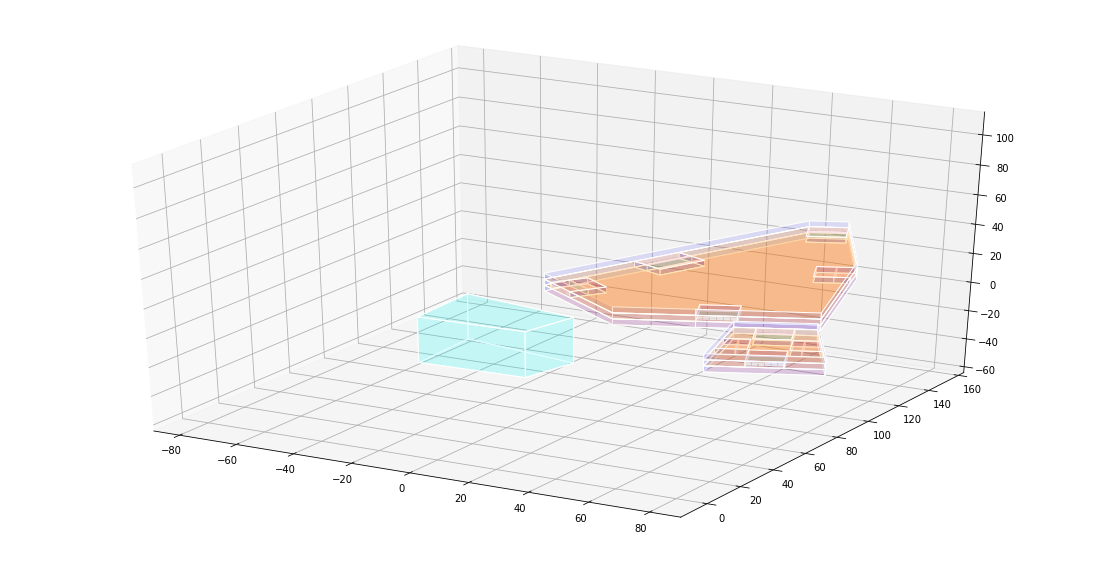

In [46]:
# Visualise the Radiance Geometry (from the geometry.json)
% matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

fig = plt.figure(figsize=(15, 7.5))
ax = Axes3D(fig)
xs, ys, zs = list(zip(*[item for sublist in [srf["vertices"][0] for srf in load_json("TESTTESTTEST/geometry.json")["surfaces"]] for item in sublist]))# ax.set_xlim([min(xs), max(xs)])
ax.set_ylim([min(ys), max(ys)])
ax.set_zlim([min(zs), max(zs)])

for srf in load_json("TESTTESTTEST/geometry.json")["surfaces"]:
    if srf["surface_type"] == 0:
        col = (0, 0, 1, 0.1)
    elif srf["surface_type"] == 1:
        col = (0, 1, 0, 0.1)
    elif srf["surface_type"] == 2:
        col = (1, 0, 0, 0.1)
    elif srf["surface_type"] == 3:
        col = (1, 1, 0, 0.1)
    elif srf["surface_type"] == 4:
        col = (0, 1, 1, 0.1)
    elif srf["surface_type"] == 5:
        col = (1, 1, 1, 0.1)

    [ax.add_collection3d(Poly3DCollection([srf["vertices"][0]], facecolor=col, edgecolor="w", zorder=0))]

def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

axisEqual3D(ax)